In [112]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D
import torch.nn as nn
from torch.utils.data import DataLoader
%matplotlib inline
import seaborn

In [2]:
np.random.seed(1)
torch.manual_seed(1)

### Part A

In [3]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

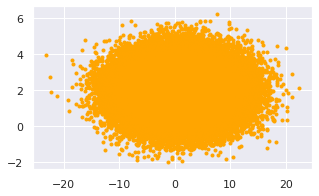

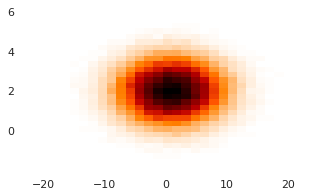

In [113]:
data1 = sample_data_1()

plt.figure(figsize=(5, 3))
plt.scatter(data1[:, 0], data1[:, 1], marker='.', c='orange')
plt.show()

plt.figure(figsize=(5, 3))
plt.hist2d(data1[:, 0], data1[:, 1], cmap="gist_heat_r", bins=30)
plt.show()

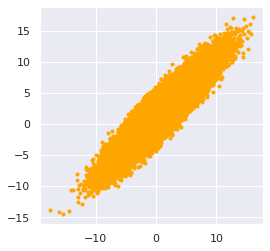

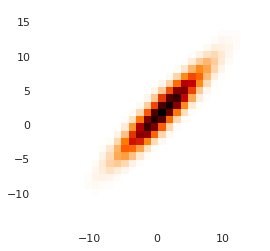

In [114]:
data2 = sample_data_2()

plt.figure(figsize=(4, 4))
plt.scatter(data2[:, 0], data2[:, 1], marker='.', c='orange')
plt.show()

plt.figure(figsize=(4, 4))
plt.hist2d(data2[:, 0], data2[:, 1], cmap="gist_heat_r", bins=30)
plt.show()

In [6]:
class Config1(nn.Module):
    def __init__(self, num_layers, num_in, num_out):
        super(Config1, self).__init__()
        list_layers = []
        list_layers.append(nn.Linear(2, num_in))
        
        for i in range(num_layers - 2):
            list_layers.append(nn.Linear(num_in, num_in))
        
        self.layers = nn.ModuleList(list_layers)
        self.outlayer = nn.Linear(num_in, num_out)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        var = torch.exp(log_var)
        return mu, var

In [7]:
class VAE1(nn.Module):
    def __init__(self, num_layers, num_in, num_out):
        super(VAE1, self).__init__()
        self.encoder = Config1(num_layers, num_in, num_out)
        self.decoder = Config1(num_layers, num_in, num_out)
            
    def forward(self, x):
        mu_enc, var_enc = self.encoder(x)
        epsilon = torch.randn(x.shape).cuda()
        sampled = mu_enc + epsilon * torch.sqrt(var_enc)
        mu_dec, var_dec = self.decoder(sampled)
        return mu_enc, var_enc, mu_dec, var_dec

In [8]:
def LossFunc(x, mu, var):
    res = -(torch.log(2 * np.pi * var) / 2 + torch.pow(x - mu, 2) / var)
    pr = torch.sum(res, dim=1, keepdim=True)
    loss = -torch.sum(pr, dim=1, keepdim=True)
    return loss

In [9]:
def KLDLoss(mu, var):
    kld = torch.log(var) - torch.pow(mu, 2) - var + 1.0
    kld = -torch.sum(kld, dim=1, keepdim=True) / 2
    return kld

In [19]:
NUM_EPOCHS = 8
LR = 1e-3
BATCH_SIZE = 128
NUM_SAMPLES = 50000
NUM_IN = 64
NUM_LAYERS = 5

In [20]:
def train(model, train_dataset):
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    kld_looses, dec_looses, elbo_looses = [], [], []

    for i in range(NUM_EPOCHS):
        for batch in dataloader:
            batch = batch.float().cuda()

            mu_enc, var_enc, mu_dec, var_dec = model(batch)
            nll = LossFunc(batch, mu_dec, var_dec)
            kld = KLDLoss(mu_enc, var_enc)
            loss = torch.mean(nll + kld)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            kld_looses.append(torch.mean(kld).detach().item())
            dec_looses.append(torch.mean(nll).detach().item())
            elbo_looses.append(torch.mean(-loss).detach().item())
            
        print(f"Epoch {i + 1}/{NUM_EPOCHS} Loss: {loss.item()}")
        
    print(f"Final Loss: {-elbo_looses[-1]}")
    
    return elbo_looses, kld_looses, dec_looses

In [21]:
def draw(elbo_looses, kld_looses, dec_looses, noisy_x, mu_x):
    seaborn.set(style='darkgrid')
    f, axarr = plt.subplots(2, 2, figsize=(14, 8))

    ax = axarr[0][0]
    ax.plot(np.arange(len(elbo_looses)), elbo_looses, c='orange')
    ax.set_title("ELBO")

    ax = axarr[0][1]
    ax.plot(np.arange(len(kld_looses)), kld_looses, c='orange')
    ax.set_title("KLD")

    ax = axarr[1][0]
    ax.plot(np.arange(len(dec_looses)), dec_looses, c='orange')
    ax.set_title("decoder term")
    
    ax = axarr[1][1]
    noisy_x = noisy_x.cpu().data.numpy()
    mu_x = mu_x.cpu().data.numpy()
    ax.scatter(noisy_x[:, 0], noisy_x[:, 1], marker='.', c='orange', label="samples")
    ax.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', c='sienna', label="mean")
    ax.legend()
    
    plt.show()

In [22]:
model = VAE1(num_layers=NUM_LAYERS, num_in=NUM_IN, num_out=4).cuda()
elbo_looses, kld_looses, dec_looses = train(model, data1)

Epoch 1/8 Loss: 5.230010986328125
Epoch 2/8 Loss: 5.021106243133545
Epoch 3/8 Loss: 5.043022632598877
Epoch 4/8 Loss: 5.020595550537109
Epoch 5/8 Loss: 5.078216552734375
Epoch 6/8 Loss: 4.995573997497559
Epoch 7/8 Loss: 5.081742286682129
Epoch 8/8 Loss: 5.198408603668213
Final Loss: 5.198408603668213


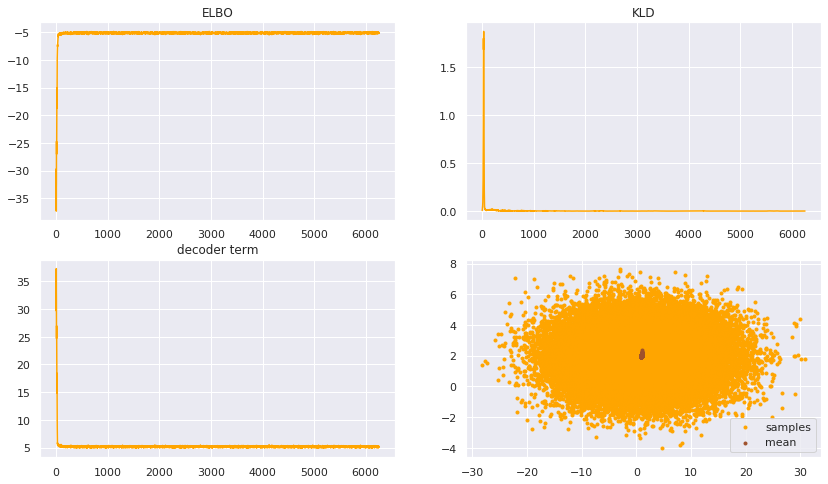

In [23]:
z = torch.randn([NUM_SAMPLES, 2]).cuda()
mu_x, var_x = model.decoder(z)
x = mu_x + torch.randn([NUM_SAMPLES, 2]).cuda() * torch.sqrt(var_x)

draw(elbo_looses, kld_looses, dec_looses, x, mu_x)

In [24]:
model = VAE1(num_layers=NUM_LAYERS, num_in=NUM_IN, num_out=4).cuda()
elbo_looses, kld_looses, dec_looses = train(model, data2)

Epoch 1/8 Loss: 5.934144973754883
Epoch 2/8 Loss: 5.484055519104004
Epoch 3/8 Loss: 4.819915771484375
Epoch 4/8 Loss: 4.919648170471191
Epoch 5/8 Loss: 5.25004768371582
Epoch 6/8 Loss: 5.235093116760254
Epoch 7/8 Loss: 5.2363600730896
Epoch 8/8 Loss: 4.880279541015625
Final Loss: 4.880279541015625


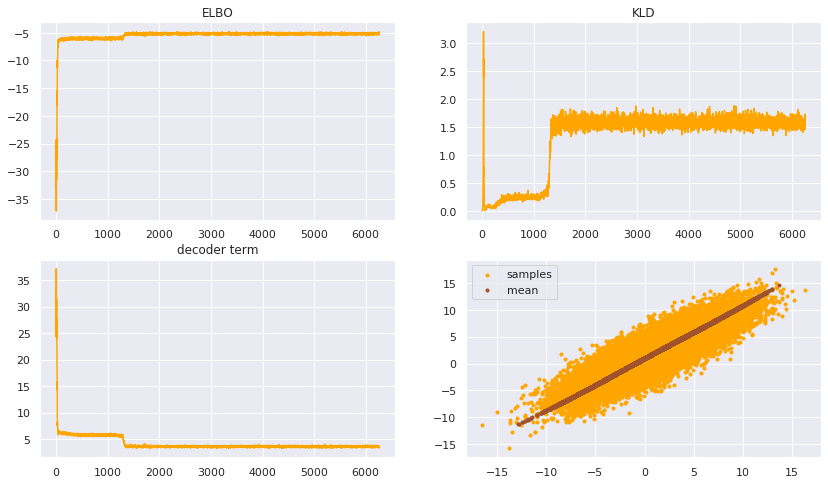

In [25]:
z = torch.randn([NUM_SAMPLES, 2]).cuda()
mu_x, var_x = model.decoder(z)
x = mu_x + torch.randn([NUM_SAMPLES, 2]).cuda() * torch.sqrt(var_x)

draw(elbo_looses, kld_looses, dec_looses, x, mu_x)

In [26]:
class Config2(nn.Module):
    def __init__(self, num_layers, num_in, num_out):
        super(Config2, self).__init__()
        list_layers = []
        list_layers.append(nn.Linear(2, num_in))
        
        for i in range(num_layers - 2):
            list_layers.append(nn.Linear(num_in, num_in))
        
        self.layers = nn.ModuleList(list_layers)
        self.outlayer = nn.Linear(num_in, num_out)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        z = self.outlayer(x)
        mu, log_var = torch.split(z, 2, dim=1)
        ones = torch.ones([1, 2], dtype=torch.float32).cuda()
        logv = log_var * ones
        var = torch.exp(logv)
        return mu, var

In [27]:
class VAE2(nn.Module):
    def __init__(self, num_layers, num_in, num_out):
        super(VAE2, self).__init__()
        self.encoder = Config2(num_layers, num_in, num_out)
        self.decoder = Config2(num_layers, num_in, num_out)
            
    def forward(self, x):
        mu_enc, var_enc = self.encoder(x)
        epsilon = torch.randn(x.shape).cuda()
        sampled = mu_enc + epsilon * torch.sqrt(var_enc)
        mu_dec, var_dec = self.decoder(sampled)
        return mu_enc, var_enc, mu_dec, var_dec

In [32]:
model = VAE2(num_layers=NUM_LAYERS, num_in=NUM_IN, num_out=3).cuda()
elbo_looses, kld_looses, dec_looses = train(model, data1)

Epoch 1/8 Loss: 6.1241302490234375
Epoch 2/8 Loss: 6.469059944152832
Epoch 3/8 Loss: 5.255578994750977
Epoch 4/8 Loss: 5.177626132965088
Epoch 5/8 Loss: 5.313254356384277
Epoch 6/8 Loss: 5.457829475402832
Epoch 7/8 Loss: 5.232365608215332
Epoch 8/8 Loss: 5.612806797027588
Final Loss: 5.612806797027588


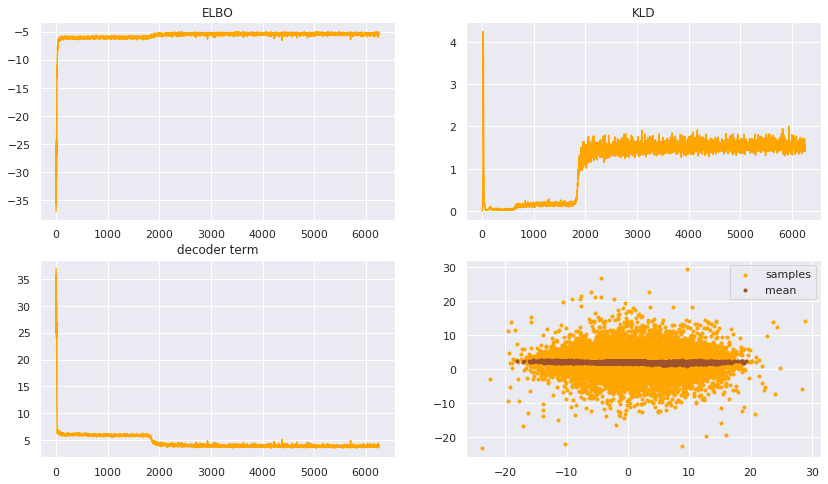

In [33]:
z = torch.randn([NUM_SAMPLES, 2]).cuda()
mu_x, var_x = model.decoder(z)
x = mu_x + torch.randn([NUM_SAMPLES, 2]).cuda() * torch.sqrt(var_x)

draw(elbo_looses, kld_looses, dec_looses, x, mu_x)

In [30]:
model = VAE2(num_layers=NUM_LAYERS, num_in=NUM_IN, num_out=3).cuda()
elbo_looses, kld_looses, dec_looses = train(model, data2)

Epoch 1/8 Loss: 5.821011066436768
Epoch 2/8 Loss: 6.2487640380859375
Epoch 3/8 Loss: 5.137294769287109
Epoch 4/8 Loss: 5.431253910064697
Epoch 5/8 Loss: 5.502634525299072
Epoch 6/8 Loss: 5.363076210021973
Epoch 7/8 Loss: 5.329768657684326
Epoch 8/8 Loss: 5.407471656799316
Final Loss: 5.407471656799316


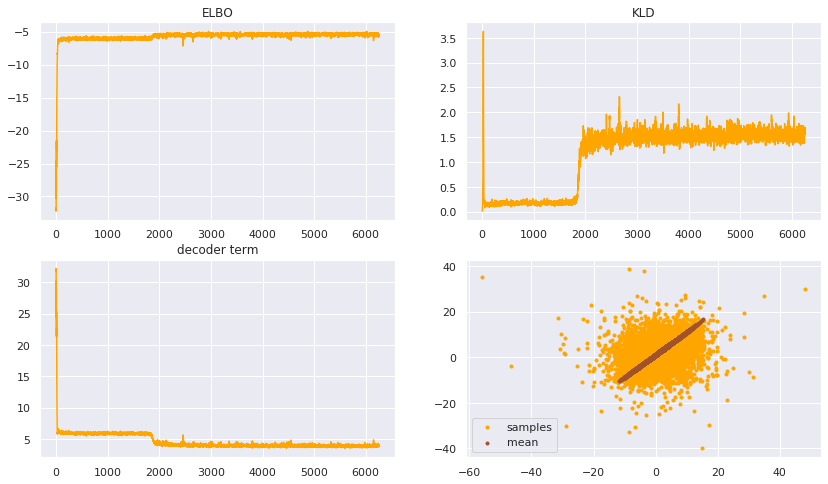

In [31]:
z = torch.randn([NUM_SAMPLES, 2]).cuda()
mu_x, var_x = model.decoder(z)
x = mu_x + torch.randn([NUM_SAMPLES, 2]).cuda() * torch.sqrt(var_x)

draw(elbo_looses, kld_looses, dec_looses, x, mu_x)

### Part B

In [34]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

X shape:  (99999, 2)
y shape:  (99999,)


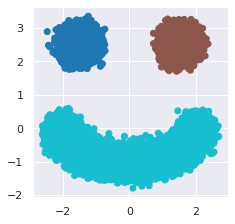

In [115]:
X, y = sample_data_3()
print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.figure(figsize=(3.5, 3.5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
plt.show()

In [37]:
split = int(0.8 * 100000)
X_train, X_test = X[:split,], X[split:,]
y_train, y_test = y[:split,], y[split:,]

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (80000, 2)
X_test shape:  (19999, 2)


In [94]:
NUM_EPOCHS = 1000
LR = 2e-4
BATCH_SIZE = 10000
NUM_SAMPLES = 1000
NUM_IN = 512
NUM_LAYERS = 3
DEVICE = torch.device("cuda")

In [95]:
def train(model, train_dataset, val_dataset):
    dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_batch = torch.from_numpy(val_dataset).float().cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    kld_looses, dec_looses, elbo_looses = [], [], []
    val_steps, val_kld_looses, val_dec_looses, val_elbo_looses = [], [], [], []
    
    with torch.no_grad():
        mu_enc, var_enc, mu_dec, var_dec = model(val_batch)
        nll = LossFunc(val_batch, mu_dec, var_dec)
        kld = KLDLoss(mu_enc, var_enc)
        loss = torch.mean(nll + kld)

        val_steps.append(0)
        val_kld_looses.append(torch.mean(kld).detach().item())
        val_dec_looses.append(torch.mean(nll).detach().item())
        val_elbo_looses.append(torch.mean(-loss).detach().item())

    for i in range(NUM_EPOCHS):
        for batch in dataloader:
            batch = batch.float().cuda()

            mu_enc, var_enc, mu_dec, var_dec = model(batch)
            nll = LossFunc(batch, mu_dec, var_dec)
            kld = KLDLoss(mu_enc, var_enc)
            loss = torch.mean(nll + kld)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            kld_looses.append(torch.mean(kld).detach().item())
            dec_looses.append(torch.mean(nll).detach().item())
            elbo_looses.append(torch.mean(-loss).detach().item())
            
        if i % 10 == 0:
            print(f"Epoch {i + 1}/{NUM_EPOCHS} Loss: {loss.item()}")
        
        with torch.no_grad():
            mu_enc, var_enc, mu_dec, var_dec = model(val_batch)
            nll = LossFunc(val_batch, mu_dec, var_dec)
            kld = KLDLoss(mu_enc, var_enc)
            loss = torch.mean(nll + kld)

            val_steps.append(len(kld_looses) - 1)
            val_kld_looses.append(torch.mean(kld).detach().item())
            val_dec_looses.append(torch.mean(nll).detach().item())
            val_elbo_looses.append(torch.mean(-loss).detach().item())
                
        
    print(f"Final Loss: {-elbo_looses[-1]}")
    
    return elbo_looses, kld_looses, dec_looses, val_steps, val_kld_looses, val_dec_looses, val_elbo_looses

In [96]:
def draw(elbo_looses, kld_looses, dec_looses, val_steps, val_kld_looses, val_dec_looses, val_elbo_looses):
    seaborn.set(style='darkgrid')
    f, axarr = plt.subplots(2, 2, figsize=(14, 8))

    ax = axarr[0][0]
    ax.plot(np.arange(len(elbo_looses)), elbo_looses, c='orange', label='train')
    ax.plot(val_steps, val_elbo_looses, c='maroon', label='val')
    ax.legend()
    ax.set_title("ELBO")

    ax = axarr[0][1]
    ax.plot(np.arange(len(kld_looses)), kld_looses, c='orange', label='train')
    ax.plot(val_steps, val_kld_looses, c='maroon', label='val')
    ax.legend()
    ax.set_title("KLD")

    ax = axarr[1][0]
    ax.plot(np.arange(len(dec_looses)), dec_looses, c='orange', label='train')
    ax.plot(val_steps, val_dec_looses, c='maroon', label='val')
    ax.legend()
    ax.set_title("decoder term")
    
    axarr[1, 1].axis('off')
    
    plt.show()

In [97]:
model = VAE1(num_layers=NUM_LAYERS, num_in=NUM_IN, num_out=4).cuda()
elbo_looses, kld_looses, dec_looses, val_steps, val_kld_looses, val_dec_looses, val_elbo_looses = train(model, X_train, X_test)



Epoch 1/1000 Loss: 5.076818943023682
Epoch 11/1000 Loss: 4.3565874099731445
Epoch 21/1000 Loss: 4.114156723022461
Epoch 31/1000 Loss: 3.656532049179077
Epoch 41/1000 Loss: 2.938711166381836
Epoch 51/1000 Loss: 2.793394088745117
Epoch 61/1000 Loss: 2.6883914470672607
Epoch 71/1000 Loss: 2.66591739654541
Epoch 81/1000 Loss: 2.5959062576293945
Epoch 91/1000 Loss: 2.514962911605835
Epoch 101/1000 Loss: 2.5404245853424072
Epoch 111/1000 Loss: 2.472971200942993
Epoch 121/1000 Loss: 2.4508965015411377
Epoch 131/1000 Loss: 2.4440011978149414
Epoch 141/1000 Loss: 2.4796974658966064
Epoch 151/1000 Loss: 2.3680272102355957
Epoch 161/1000 Loss: 2.361598491668701
Epoch 171/1000 Loss: 2.318690299987793
Epoch 181/1000 Loss: 2.3236138820648193
Epoch 191/1000 Loss: 2.308584213256836
Epoch 201/1000 Loss: 2.270355701446533
Epoch 211/1000 Loss: 2.2967617511749268
Epoch 221/1000 Loss: 2.258035898208618
Epoch 231/1000 Loss: 2.2589361667633057
Epoch 241/1000 Loss: 2.2150022983551025
Epoch 251/1000 Loss: 2.25

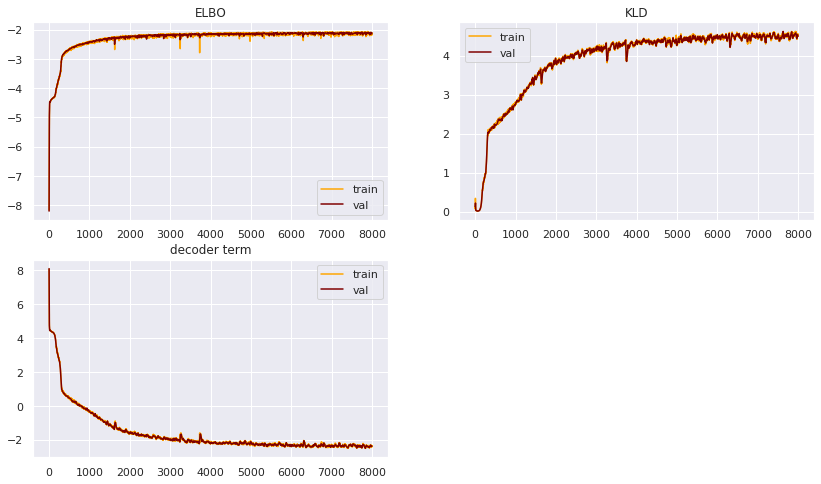

In [98]:
draw(elbo_looses, kld_looses, dec_looses, val_steps, val_kld_looses, val_dec_looses, val_elbo_looses)

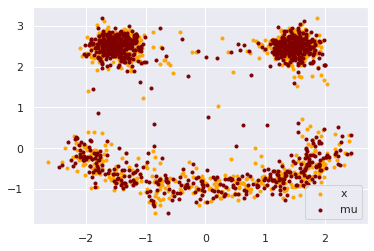

In [132]:
z = torch.randn([NUM_SAMPLES, 2]).cuda()
mu, var = model.decoder(z)
x = mu + torch.randn([NUM_SAMPLES, 2]).cuda() * torch.sqrt(var)
x = x.cpu().data.numpy()
mu = mu.cpu().data.numpy()

plt.scatter(x[:, 0], x[:, 1], marker='.', c='orange', label='x')
plt.scatter(mu[:, 0], mu[:, 1], marker='.', c='maroon', label='mu')
plt.legend()
plt.show()

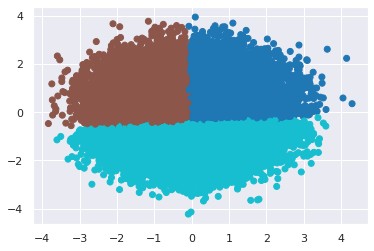

In [133]:
mu_enc, var_enc = model.encoder(torch.from_numpy(X_train).float().cuda())
sampled = mu_enc + torch.randn(X_train.shape).float().cuda() * torch.sqrt(var_enc)
lat = sampled.cpu().data.numpy()
plt.scatter(lat[:, 0], lat[:, 1], c=y_train, cmap='tab10')
plt.show()

In [196]:
x100 = torch.from_numpy(X_test[:100]).float().cuda()

In [218]:
def print_IWAE(label, num):
    with torch.no_grad():
        def prob(x, mu, var):
            pr = torch.exp(-torch.pow(x - mu, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var)
            pr1 = pr[:, :, :1]
            pr2 = pr[:, :, 1:]
            return pr1 * pr2

        mu_enc, var_enc = model.encoder(x100)
        
        mu_enc = torch.unsqueeze(mu_enc, dim=0).repeat(num, 1, 1)
        var_enc = torch.unsqueeze(var_enc, dim=0).repeat(num, 1, 1)
        
        z = mu_enc + torch.randn(mu_enc.shape).cuda() * torch.sqrt(var_enc)
        
        mu_dec, var_dec = model.decoder(z.reshape((-1, 2)))
        
        mu_dec = mu_dec.reshape(z.shape)
        var_dec = var_dec.reshape(z.shape)

        prob_dec = prob(x100, mu_dec, var_dec)
        
        zeros = torch.zeros_like(mu_enc).cuda()
        ones = torch.ones_like(var_enc).cuda()
        prob_z = prob(z, zeros, ones)
        
        prob_enc = prob(z, mu_enc, var_enc)

        mn = torch.mean((prob_dec * prob_z) / prob_enc, dim=0)
        iwae = torch.mean(torch.log(mn))

        print(f"{label}: {iwae.item()}")

In [219]:
print_IWAE("IWAE", 100)
print_IWAE("ELBO", 1)

IWAE: -1.4916212558746338
ELBO: -1.665299892425537
